## **Câu 4: Clustering – Movies Clustering (1.0 điểm)**
Build a clustering model to cluster the movies in tmdb_5000_movies.csv dataset.
Explain the main characteristics of each cluster. Use Word Cloud to visualize each 
cluster.
(Hint: Use some features such as 'title', 'tagline', 'overview', 'popularity'…)

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.3/spark-3.1.3-bin-hadoop3.2.tgz
!tar xf spark-3.1.3-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
import pyspark
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import Tokenizer,StopWordsRemover
from pyspark.ml.feature import CountVectorizer,IDF,StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

from scipy import stats
from datetime import datetime
from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer, OneHotEncoder, Bucketizer, VectorAssembler, StringIndexer
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import round

from pyspark.sql.functions import regexp_extract, col
from pyspark.sql.functions import datediff
from pyspark.sql.functions import when

from pyspark.ml.linalg import Vectors


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier, LinearSVC
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LogisticRegressionModel

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import datetime
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import iqr
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from scipy.stats import iqr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/LDS9_K273_ONLINE_Đinh Viết Trung/LDS9_K273_DinhVietTrung_Cuoi_ky'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS9_K273_ONLINE_Đinh Viết Trung/LDS9_K273_DinhVietTrung_Cuoi_ky


In [ ]:
from pyspark import SparkContext
sc = SparkContext()


In [ ]:
spark = SparkSession(sc)

In [ ]:
df_pd = pd.read_csv('data/tmdb_5000_movies.csv')

In [ ]:
df = spark.createDataFrame(df_pd.astype('str')) # vì spark khi đọc data có các cell dạng list có cấu trúc bị lỗi nên phải làm gián tiếp như này ạ:()

### **Phân tích khai phá dữ liệu và tiền xử lý (EDA & Preprocessing)**

In [ ]:
df.show(5)

+---------+--------------------+--------------------+------+--------------------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+------------+----------+-------+--------------------+--------+--------------------+--------------------+------------+----------+
|   budget|              genres|            homepage|    id|            keywords|original_language|      original_title|            overview|popularity|production_companies|production_countries|release_date|   revenue|runtime|    spoken_languages|  status|             tagline|               title|vote_average|vote_count|
+---------+--------------------+--------------------+------+--------------------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+------------+----------+-------+--------------------+--------+--------------------+--------------------+------------+----------+
|237000000|[{"id": 28, "name...

In [ ]:
df.printSchema()

root
 |-- budget: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nullable = true)



In [ ]:
df.describe().show()

+-------+--------------------+--------------------+--------------------+------------------+--------------------+-----------------+------------------+--------------------+------------------+--------------------+--------------------+------------+--------------------+-------+--------------------+---------------+--------------------+------------------+------------------+-----------------+
|summary|              budget|              genres|            homepage|                id|            keywords|original_language|    original_title|            overview|        popularity|production_companies|production_countries|release_date|             revenue|runtime|    spoken_languages|         status|             tagline|             title|      vote_average|       vote_count|
+-------+--------------------+--------------------+--------------------+------------------+--------------------+-----------------+------------------+--------------------+------------------+--------------------+--------------

'''
Vì mục đích của bài này là phân cụm dữ liệu và bộ dataset này có khá nhiều field
=> ta sẽ phân tích các field 'title', 'tagline', 'overview', 'budget' ,'revenue','popularity', 'vote_count', 'vote_average', 'runtime' để phân cụm
'''

In [ ]:
df_new = df.select('title', 'tagline', 'overview', 'budget' ,'revenue','popularity', 'vote_count', 'vote_average', 'runtime')

In [ ]:
df_new.show(5)

+--------------------+--------------------+--------------------+---------+----------+----------+----------+------------+-------+
|               title|             tagline|            overview|   budget|   revenue|popularity|vote_count|vote_average|runtime|
+--------------------+--------------------+--------------------+---------+----------+----------+----------+------------+-------+
|              Avatar|Enter the World o...|In the 22nd centu...|237000000|2787965087|150.437577|     11800|         7.2|  162.0|
|Pirates of the Ca...|At the end of the...|Captain Barbossa,...|300000000| 961000000|139.082615|      4500|         6.9|  169.0|
|             Spectre|A Plan No One Esc...|A cryptic message...|245000000| 880674609|107.376788|      4466|         6.3|  148.0|
|The Dark Knight R...|     The Legend Ends|Following the dea...|250000000|1084939099| 112.31295|      9106|         7.6|  165.0|
|         John Carter|Lost in our world...|John Carter is a ...|260000000| 284139100| 43.926995| 

### **Clean Data**

**Check missing data**

In [ ]:
df_new.select([count(when(isnan(c), c)).alias(c) for c in df_new.columns]).toPandas().T

,0
title,0
tagline,844
overview,3
budget,0
revenue,0
popularity,0
vote_count,0
vote_average,0
runtime,2


'''
mặc dù có nan tại tagline và runtime nhưng em không xử lý vì sau cùng em chỉ phân tích các biến này chứ không dùng 2 biến này để clustering
'''

In [ ]:
df_new.select([count(when(col(c).isNull(), c)).alias(c) for c in df_new.columns]).toPandas().T

,0
title,0
tagline,0
overview,0
budget,0
revenue,0
popularity,0
vote_count,0
vote_average,0
runtime,0


**Check duplicates**

In [ ]:
total = df_new.count()
distinct = df_new.distinct().count()

print('df', 'có', total, 'records')
print('df', 'có', distinct, 'distinct records')
if total > distinct:
    print('df', 'có các duplicate records với ' + str(total - distinct) + ' duplicate records')
else:
    print('df', 'ko có duplicate records')

df có 4803 records
df có 4803 distinct records
df ko có duplicate records


In [ ]:
df_new.show(5, truncate=False)

+----------------------------------------+----------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+----------+----------+----------+------------+-------+
|title                                   |tagline                                       |overview                                                                                                                                                                                                                                                                                                                                

In [ ]:
df_new.printSchema()

root
 |-- title: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- runtime: string (nullable = true)



In [ ]:
df_new = df_new.withColumn("popularity",col("popularity").cast("double"))
df_new = df_new.withColumn("vote_count",col("vote_count").cast("int"))
df_new = df_new.withColumn("vote_average",col("vote_average").cast("double"))
df_new = df_new.withColumn("budget",col("budget").cast("double"))
df_new = df_new.withColumn("revenue",col("revenue").cast("double"))
df_new = df_new.withColumn("runtime",col("runtime").cast("int"))


In [ ]:
df_new.printSchema()

root
 |-- title: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- budget: double (nullable = true)
 |-- revenue: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- runtime: integer (nullable = true)



### **Phân tích tổng quan các biến**

#### **budget, revenue, popularity, vote_count, vote_average, runtime**

In [ ]:
def continuous_univariate_analysis(f):
    print("1\ Describe: \n", f.describe(), "\n")
    print("2\ Meadian: ", f.median())
    print("3\ Mode: ", f.mode)
    print("4\ Range: ", f.values.ptp())
    print("5\ Variance: ", f.var())
    print("6\ Số NaN: ", f.isnull().sum())
    print("7\ \tQ1 = ", np.quantile(f, 0.25))
    print("   \tQ3 = ", np.quantile(f, 0.75))
    print("   \tIQR = ", iqr(f))

    print("8\ Skew: ", f.skew())
    if f.skew() > 0:
        print("Phân phối lệch phải")
    elif f.skew() == 0:
        print("Phân phối đối xứng")
    else:
        print("Phân phối lệch trái")

    print("9\ Kurtosis: ", f.kurtosis())
    if f.kurtosis() > 0:
        print("Phân phối nhọn hơn pp chuẩn")
    elif f.kurtosis() == 0:
        print("Phân phối đối xứng")
    else:
        print("Phân phối bẹt hơn pp chuẩn")

In [ ]:
def visualize_histogram(f):
    # Histogram
    plt.subplot(1, 2, 1)
    sns.distplot(f)

    plt.subplot(1, 2, 2)
    plt.hist(f)
    plt.show()

In [ ]:
def visualize_boxplot(f):
    plt.boxplot(f)
    plt.show()

In [ ]:
def find_outliers(f):
    Q1 = np.quantile(f, 0.25)
    Q3 = np.quantile(f, 0.75)
    IQR = Q3 - Q1

    # số lượng outliers
    num_outliers = len(f[(f > Q3 + 1.5 * IQR) | (f < Q1 - 1.5 * IQR)])

    # tỉ lệ outliers so với mẫu
    ratio = num_outliers / f.shape[0]

    print("Số lượng outliers: ", num_outliers)
    print("Tỉ lệ outliers so với mẫu", ratio)

In [ ]:
df_new.columns

['title',
 'tagline',
 'overview',
 'budget',
 'revenue',
 'popularity',
 'vote_count',
 'vote_average',
 'runtime']

In [ ]:
df_pd = df_new.toPandas()

budget
1\ Describe: 
 count    4.803000e+03
mean     2.904504e+07
std      4.072239e+07
min      0.000000e+00
25%      7.900000e+05
50%      1.500000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64 

2\ Meadian:  15000000.0
3\ Mode:  <bound method Series.mode of 0       237000000.0
1       300000000.0
2       245000000.0
3       250000000.0
4       260000000.0
           ...     
4798       220000.0
4799         9000.0
4800            0.0
4801            0.0
4802            0.0
Name: budget, Length: 4803, dtype: float64>
4\ Range:  380000000.0
5\ Variance:  1658313149814356.8
6\ Số NaN:  0
7\ 	Q1 =  790000.0
   	Q3 =  40000000.0
   	IQR =  39210000.0
8\ Skew:  2.4372110287256867
Phân phối lệch phải
9\ Kurtosis:  7.658060224493607
Phân phối nhọn hơn pp chuẩn


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


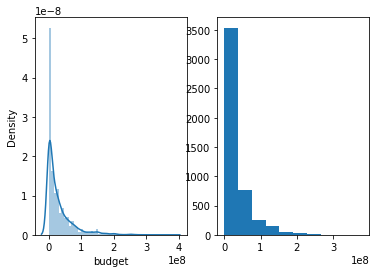

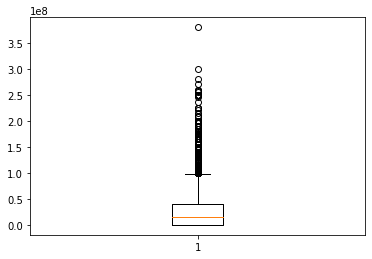

Số lượng outliers:  321
Tỉ lệ outliers so với mẫu 0.06683322923173017



revenue
1\ Describe: 
 count    4.803000e+03
mean     8.226064e+07
std      1.628571e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.917000e+07
75%      9.291719e+07
max      2.787965e+09
Name: revenue, dtype: float64 

2\ Meadian:  19170001.0
3\ Mode:  <bound method Series.mode of 0       2.787965e+09
1       9.610000e+08
2       8.806746e+08
3       1.084939e+09
4       2.841391e+08
            ...     
4798    2.040920e+06
4799    0.000000e+00
4800    0.000000e+00
4801    0.000000e+00
4802    0.000000e+00
Name: revenue, Length: 4803, dtype: float64>
4\ Range:  2787965087.0
5\ Variance:  2.652243532750183e+16
6\ Số NaN:  0
7\ 	Q1 =  0.0
   	Q3 =  92917187.0
   	IQR =  92917187.0
8\ Skew:  4.444716447519764
Phân phối lệch phải
9\ Kurtosis:  33.123629663045584
Phân phối nhọn hơn pp chuẩn


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


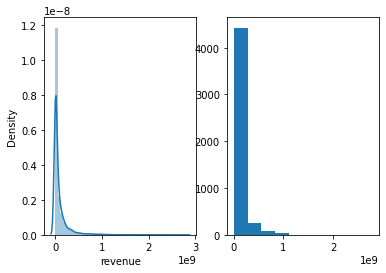

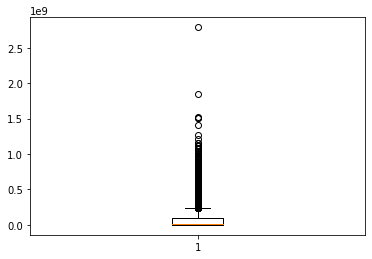

Số lượng outliers:  472
Tỉ lệ outliers so với mẫu 0.09827191338746617



popularity
1\ Describe: 
 count    4803.000000
mean       21.492301
std        31.816650
min         0.000000
25%         4.668070
50%        12.921594
75%        28.313505
max       875.581305
Name: popularity, dtype: float64 

2\ Meadian:  12.921594
3\ Mode:  <bound method Series.mode of 0       150.437577
1       139.082615
2       107.376788
3       112.312950
4        43.926995
           ...    
4798     14.269792
4799      0.642552
4800      1.444476
4801      0.857008
4802      1.929883
Name: popularity, Length: 4803, dtype: float64>
4\ Range:  875.581305
5\ Variance:  1012.2992012847641
6\ Số NaN:  0
7\ 	Q1 =  4.66807
   	Q3 =  28.3135045
   	IQR =  23.6454345
8\ Skew:  9.721415886274542
Phân phối lệch phải
9\ Kurtosis:  191.99582047799055
Phân phối nhọn hơn pp chuẩn


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


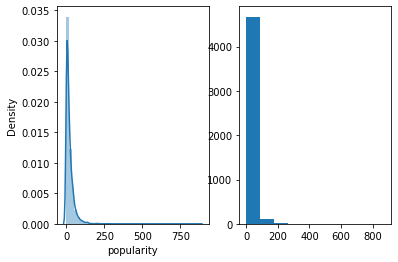

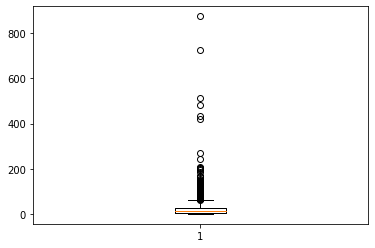

Số lượng outliers:  275
Tỉ lệ outliers so với mẫu 0.05725588174057881



vote_count
1\ Describe: 
 count     4803.000000
mean       690.217989
std       1234.585891
min          0.000000
25%         54.000000
50%        235.000000
75%        737.000000
max      13752.000000
Name: vote_count, dtype: float64 

2\ Meadian:  235.0
3\ Mode:  <bound method Series.mode of 0       11800
1        4500
2        4466
3        9106
4        2124
        ...  
4798      238
4799        5
4800        6
4801        7
4802       16
Name: vote_count, Length: 4803, dtype: int32>
4\ Range:  13752
5\ Variance:  1524202.3216921636
6\ Số NaN:  0
7\ 	Q1 =  54.0
   	Q3 =  737.0
   	IQR =  683.0
8\ Skew:  3.824068535476413
Phân phối lệch phải
9\ Kurtosis:  19.913946184645337
Phân phối nhọn hơn pp chuẩn


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


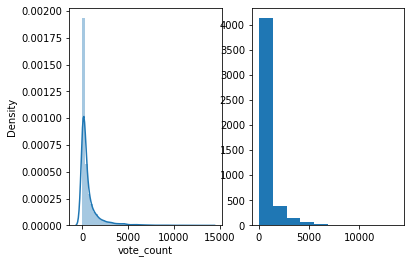

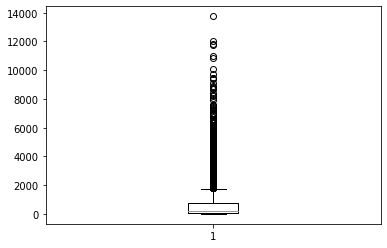

Số lượng outliers:  504
Tỉ lệ outliers so với mẫu 0.10493441599000625



vote_average
1\ Describe: 
 count    4803.000000
mean        6.092172
std         1.194612
min         0.000000
25%         5.600000
50%         6.200000
75%         6.800000
max        10.000000
Name: vote_average, dtype: float64 

2\ Meadian:  6.2
3\ Mode:  <bound method Series.mode of 0       7.2
1       6.9
2       6.3
3       7.6
4       6.1
       ... 
4798    6.6
4799    5.9
4800    7.0
4801    5.7
4802    6.3
Name: vote_average, Length: 4803, dtype: float64>
4\ Range:  10.0
5\ Variance:  1.4270982196241198
6\ Số NaN:  0
7\ 	Q1 =  5.6
   	Q3 =  6.8
   	IQR =  1.2000000000000002
8\ Skew:  -1.959710007198752
Phân phối lệch trái
9\ Kurtosis:  7.792362845217275
Phân phối nhọn hơn pp chuẩn


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


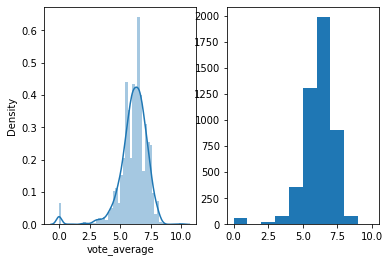

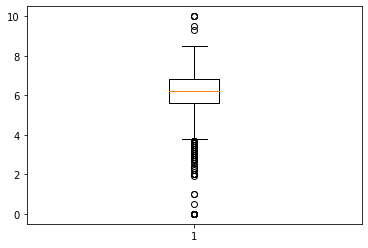

Số lượng outliers:  156
Tỉ lệ outliers so với mẫu 0.03247970018738289



runtime
1\ Describe: 
 count    4801.000000
mean      106.875859
std        22.611935
min         0.000000
25%        94.000000
50%       103.000000
75%       118.000000
max       338.000000
Name: runtime, dtype: float64 

2\ Meadian:  103.0
3\ Mode:  <bound method Series.mode of 0       162.0
1       169.0
2       148.0
3       165.0
4       132.0
        ...  
4798     81.0
4799     85.0
4800    120.0
4801     98.0
4802     90.0
Name: runtime, Length: 4803, dtype: float64>
4\ Range:  nan
5\ Variance:  511.299585850169
6\ Số NaN:  2
7\ 	Q1 =  nan
   	Q3 =  nan
   	IQR =  nan
8\ Skew:  0.7159565062897394
Phân phối lệch phải
9\ Kurtosis:  8.935448828134865
Phân phối nhọn hơn pp chuẩn


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


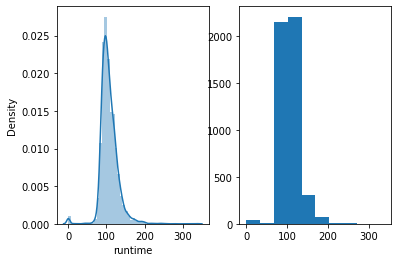

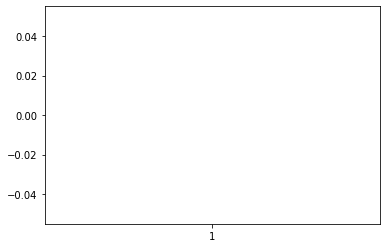

Số lượng outliers:  0
Tỉ lệ outliers so với mẫu 0.0





In [ ]:
df_continuous = df_pd[['budget', 'revenue', 'popularity', 'vote_count', 'vote_average', 'runtime']]
for i in df_continuous:
    print(i)
    continuous_univariate_analysis(df_pd[i])
    visualize_histogram(df_pd[i])
    visualize_boxplot(df_pd[i])
    find_outliers(df_pd[i])
    print("\n====================================================\n\n")

'''
'budget', 'revenue', 'popularity', 'vote_count', 'vote_average' đều có thang giá trị khác nhau => cần chuẩn hóa 
có các outliers, nhưng các outliers này hợp lệ (đặc trưng của dataset)
'''

### **Overview**


### **Tiền xử lý text cho wordcloud**

In [ ]:
# download stopwords
nltk.download("stopwords")
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from nltk.corpus.reader import reviews
from nltk.stem.porter import PorterStemmer
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

def preprocessor(text):
    #remove urls
    tweet1= re.sub(r'http\S+', ' ', text)
    #remove html tags
    tweet2 = re.sub(r'<.*?>',' ', tweet1) 
    #remove digits
    tweet3 = re.sub(r'\d+',' ', tweet2)
    #remove hashtags
    tweet4 = re.sub(r'#\w+',' ', tweet3)
    review = re.sub('[^a-zA-Z]', ' ', tweet4)
    review = review.lower()
    # review = review.split()
    # ps = PorterStemmer()
    # review = [ps.stem(word) for word in review if word not in all_stopwords]
    #review = ' '.join(review)
    return review

In [ ]:
df_pd["new_overview"] = df_pd['overview'].apply(lambda x : preprocessor(x))

In [ ]:
df_new2 = spark.createDataFrame(df_pd)

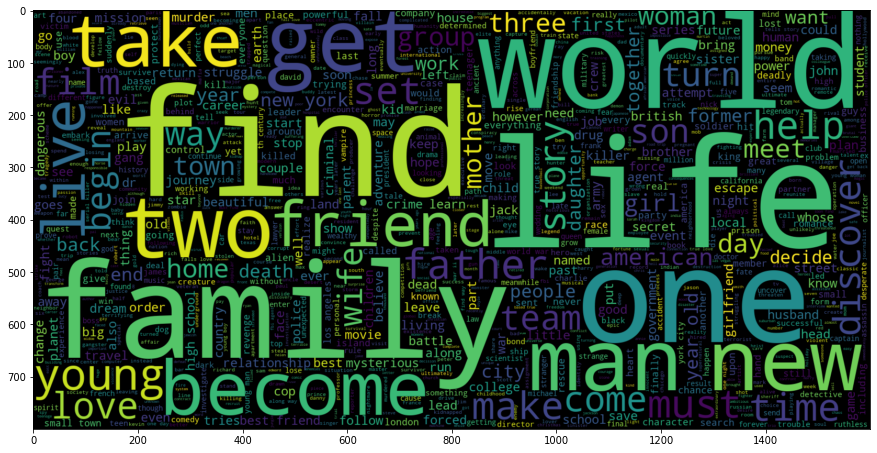

In [ ]:
plt.figure(figsize = (15,18)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = stop_words)\
    .generate(" ".join(df_pd.new_overview))

plt.imshow(wc, interpolation = 'bilinear')
plt.show()

'''
Nói chung là các overview film xoay quanh thể loại liên quan đến life, find (tìm kiếm kho báu, vật phẩm, tìm bạn, ...)
friend, family, ...
'''

### **Feature Transformations**

### **Format from data**

In [ ]:
df_new2.show(5)

+--------------------+--------------------+--------------------+------+-------------+----------+----------+------------+-------+--------------------+
|               title|             tagline|            overview|budget|      revenue|popularity|vote_count|vote_average|runtime|        new_overview|
+--------------------+--------------------+--------------------+------+-------------+----------+----------+------------+-------+--------------------+
|              Avatar|Enter the World o...|In the 22nd centu...|2.37E8|2.787965087E9|150.437577|     11800|         7.2|  162.0|in the  nd centur...|
|Pirates of the Ca...|At the end of the...|Captain Barbossa,...| 3.0E8|       9.61E8|139.082615|      4500|         6.9|  169.0|captain barbossa ...|
|             Spectre|A Plan No One Esc...|A cryptic message...|2.45E8| 8.80674609E8|107.376788|      4466|         6.3|  148.0|a cryptic message...|
|The Dark Knight R...|     The Legend Ends|Following the dea...| 2.5E8|1.084939099E9| 112.31295|    

In [ ]:
df_new2.columns

['title',
 'tagline',
 'overview',
 'budget',
 'revenue',
 'popularity',
 'vote_count',
 'vote_average',
 'runtime',
 'new_overview']

In [ ]:
# # xử lý data dạng text của title, tagline, overview
# tokenizer1 = Tokenizer(inputCol="title", outputCol="token_text1")
# stopremove1 = StopWordsRemover(inputCol='token_text1',outputCol='stop_tokens1')
# count_vec1 = CountVectorizer(inputCol='stop_tokens1',outputCol='c_vec1')
# idf1 = IDF(inputCol="c_vec1", outputCol="tf_idf_title")

# tokenizer2 = Tokenizer(inputCol="tagline", outputCol="token_text2")
# stopremove2 = StopWordsRemover(inputCol='token_text2',outputCol='stop_tokens2')
# count_vec2 = CountVectorizer(inputCol='stop_tokens2',outputCol='c_vec2')
# idf2 = IDF(inputCol="c_vec2", outputCol="tf_idf_tagline")

# tokenizer3 = Tokenizer(inputCol="overview", outputCol="token_text3")
# stopremove3 = StopWordsRemover(inputCol='token_text3',outputCol='stop_tokens3')
# count_vec3 = CountVectorizer(inputCol='stop_tokens3',outputCol='c_vec3')
# idf3 = IDF(inputCol="c_vec3", outputCol="tf_idf_overview")

In [1]:
'''
ban đầu em dùng 'tf_idf_overview','budget', 'revenue','popularity', 'vote_count', 'vote_average', 'runtime'
để phân cụm nhưng kết quả cho ra tệ quá nên em chọn 'budget', 'revenue','popularity', 'vote_average' 
(các thuộc tính liên quan đến chi phí - doanh thu, sự phổ biến và thời lượng phim -> các thuộc tính có vẻ liên quan đến nhau :))
'''

"\nban đầu em dùng 'tf_idf_overview','budget', 'revenue','popularity', 'vote_count', 'vote_average', 'runtime'\nđể phân cụm nhưng kết quả cho ra tệ quá nên em chọn 'budget', 'revenue','popularity', 'vote_average' \n(các thuộc tính liên quan đến chi phí - doanh thu, sự phổ biến và thời lượng phim -> các thuộc tính có vẻ liên quan đến nhau :))\n"

In [ ]:
vec_assembler = VectorAssembler(inputCols = ['vote_average', 'popularity', 'budget', 'revenue'], 
                                outputCol='features')

# vec_assembler = VectorAssembler(inputCols = ['tf_idf_title', 'tf_idf_tagline', 'tf_idf_overview'], 
#                                 outputCol='features')

# vec_assembler = VectorAssembler(inputCols = ['budget', 'revenue','popularity', 'vote_count', 'runtime'], 
#                                 outputCol='features')

# vec_assembler = VectorAssembler(inputCols = ['budget', 'revenue','popularity', 'vote_count'], 
#                                 outputCol='features')

In [ ]:
# data_prep_pipe = Pipeline(stages=[tokenizer1, stopremove1, count_vec1, idf1,
#                                   tokenizer2, stopremove2, count_vec2, idf2,\
#                                   tokenizer3, stopremove3, count_vec3, idf3, vec_assembler])

data_prep_pipe = Pipeline(stages=[vec_assembler])


In [ ]:
cleaner = data_prep_pipe.fit(df_new2)

In [ ]:
# clean_data = cleaner.transform(df_new2)
final_data = cleaner.transform(df_new2)

In [ ]:
#final_data = vec_assembler.transform(df_new2)


In [ ]:
final_data.show(5)

+--------------------+--------------------+--------------------+------+-------------+----------+----------+------------+-------+--------------------+--------------------+
|               title|             tagline|            overview|budget|      revenue|popularity|vote_count|vote_average|runtime|        new_overview|            features|
+--------------------+--------------------+--------------------+------+-------------+----------+----------+------------+-------+--------------------+--------------------+
|              Avatar|Enter the World o...|In the 22nd centu...|2.37E8|2.787965087E9|150.437577|     11800|         7.2|  162.0|in the  nd centur...|[7.2,150.437577,2...|
|Pirates of the Ca...|At the end of the...|Captain Barbossa,...| 3.0E8|       9.61E8|139.082615|      4500|         6.9|  169.0|captain barbossa ...|[6.9,139.082615,3...|
|             Spectre|A Plan No One Esc...|A cryptic message...|2.45E8| 8.80674609E8|107.376788|      4466|         6.3|  148.0|a cryptic message

### **Scale the Data**

In [ ]:
from pyspark.ml.feature import StandardScaler

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures" , withStd=True, withMean=False) 
scalerModel = scaler.fit(final_data)
final_data = scalerModel.transform(final_data)


In [ ]:
final_data.show(5)

+--------------------+--------------------+--------------------+------+-------------+----------+----------+------------+-------+--------------------+--------------------+--------------------+
|               title|             tagline|            overview|budget|      revenue|popularity|vote_count|vote_average|runtime|        new_overview|            features|      scaledFeatures|
+--------------------+--------------------+--------------------+------+-------------+----------+----------+------------+-------+--------------------+--------------------+--------------------+
|              Avatar|Enter the World o...|In the 22nd centu...|2.37E8|2.787965087E9|150.437577|     11800|         7.2|  162.0|in the  nd centur...|[7.2,150.437577,2...|[6.02706068456190...|
|Pirates of the Ca...|At the end of the...|Captain Barbossa,...| 3.0E8|       9.61E8|139.082615|      4500|         6.9|  169.0|captain barbossa ...|[6.9,139.082615,3...|[5.77593315603849...|
|             Spectre|A Plan No One Esc.

In [ ]:
final_data.write.parquet('Exercise3/final_data.parquet', mode = 'overwrite')

In [ ]:
#final_data = spark.read.parquet('Exercise3/final_data.parquet')

### **Train the Model and Evaluate**

In [ ]:
# Seleck k with minimun WSSSE: k between 2 - 6

# Trains a k-means model.
k_list = []
silhouette_list = []

sil_str = ''
for k in range(2,6+1): 
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model = kmeans.fit(final_data)
    k_list.append(k)

    # silhoutte
    predictions = model.transform(final_data)
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)
    
    sil_str = sil_str + "With k = " + str(k) + " -> Silhouette = " + str(silhouette) + "\n"
    print("With k =", k, "Set Sum of Squared Errors = " + str(sil_str))


With k = 2 Set Sum of Squared Errors = With k = 2 -> Silhouette = 0.870814860582492

With k = 3 Set Sum of Squared Errors = With k = 2 -> Silhouette = 0.870814860582492
With k = 3 -> Silhouette = 0.6682070756526017

With k = 4 Set Sum of Squared Errors = With k = 2 -> Silhouette = 0.870814860582492
With k = 3 -> Silhouette = 0.6682070756526017
With k = 4 -> Silhouette = 0.6563046148863334

With k = 5 Set Sum of Squared Errors = With k = 2 -> Silhouette = 0.870814860582492
With k = 3 -> Silhouette = 0.6682070756526017
With k = 4 -> Silhouette = 0.6563046148863334
With k = 5 -> Silhouette = -0.054470512693616364

With k = 6 Set Sum of Squared Errors = With k = 2 -> Silhouette = 0.870814860582492
With k = 3 -> Silhouette = 0.6682070756526017
With k = 4 -> Silhouette = 0.6563046148863334
With k = 5 -> Silhouette = -0.054470512693616364
With k = 6 -> Silhouette = 0.07670983064319756



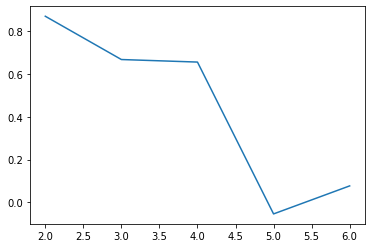

In [ ]:
plt.plot(k_list, silhouette_list)
plt.show()

'''
Ở đây, k = 2 cho silhouette cao nhất nhưng nếu vậy thì số cụm ít quá, nên em quyết định chọn k = 3
'''

### **Chọn k = 3**

In [ ]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures',k=3)
model = kmeans.fit(final_data)

In [ ]:
predictions = model.transform(final_data)
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)

print('Silhoutte = ', str(silhouette))

Silhoutte =  0.6682070756526017


In [ ]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)


Cluster Centers: 
[4.95356667 0.33641473 0.29133283 0.12330557]
[5.70077492 3.28924227 3.798774   4.2528638 ]
[5.4409515  1.27098082 1.48099502 1.04599435]


In [ ]:
predictions = model.transform(final_data)

In [ ]:
predictions.select("prediction").show(5)


+----------+
|prediction|
+----------+
|         1|
|         1|
|         1|
|         1|
|         1|
+----------+
only showing top 5 rows



In [ ]:
# Check number points of each cluster
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  195|
|         2| 1162|
|         0| 3446|
+----------+-----+



'''
Ta thấy các nhóm phân chia tạm ổn, trong đó nhóm 0 là nhiều nhất với 3446 records.
Nhóm 2 có 1162 records.
Về nhóm 1, với số lượng chỉ có 195 nhưng đây có thể là nhóm vàng hoặc nhóm rác.
'''

In [ ]:
final_data.show(3, False)


+----------------------------------------+----------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+-------------+----------+----------+------------+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------+---------------------------------------------------------------------------+
|title                                   |tagline                                       |overview                                                                                                                                                         

In [ ]:
temp = final_data.select("scaledFeatures").rdd.map(lambda x: x[0].toArray().tolist()).toDF()
temp.show(3)

+------------------+------------------+-----------------+------------------+
|                _1|                _2|               _3|                _4|
+------------------+------------------+-----------------+------------------+
|6.0270606845619055| 4.728265803730185|5.819893986462251| 17.11908827345945|
| 5.775933156038493|4.3713783850551575|7.366954413243356|5.9008787116832835|
| 5.273678098991668|3.3748615534720137|6.016346104148741|  5.40765249965463|
+------------------+------------------+-----------------+------------------+
only showing top 3 rows



In [ ]:
data_result = predictions.select('prediction')
data_result.columns

['prediction']

In [ ]:
import pyspark.sql.functions as f

In [ ]:
from pyspark.ml.feature import PCA
pca = PCA(k = 2, inputCol = 'features', outputCol = 'pca') #k = n_components
model = pca.fit(predictions)

In [ ]:
transformed = model.transform(predictions)


In [ ]:
transformed.select(['prediction', 'pca']).show(3, truncate = False)


+----------+--------------------------------------------+
|prediction|pca                                         |
+----------+--------------------------------------------+
|1         |[-2.783743466632017E9,-2.8229530338719594E8]|
|1         |[-9.998877660585037E8,1.1724101367079097E8] |
|1         |[-9.107819255760264E8,7.803237136817056E7]  |
+----------+--------------------------------------------+
only showing top 3 rows



In [ ]:
temp = transformed.select('pca').rdd.map(lambda x: x[0].toArray().tolist()).toDF()
temp.show(3)


+--------------------+--------------------+
|                  _1|                  _2|
+--------------------+--------------------+
|-2.783743466632017E9|-2.82295303387195...|
|-9.998877660585037E8|1.1724101367079097E8|
|-9.107819255760264E8| 7.803237136817056E7|
+--------------------+--------------------+
only showing top 3 rows



In [ ]:
temp = temp.withColumn('row_index', f.monotonically_increasing_id())
data_result = data_result.withColumn('row_index', f.monotonically_increasing_id())
temp = temp.join(data_result, on = ['row_index']).sort('row_index').drop('row_index')

In [ ]:
temp = temp.select(col('_1').alias('x_scale'),
                  col('_2').alias('y_scale'),'prediction')

In [ ]:
df3 = temp.toPandas()
df3.head()

,x_scale,y_scale,prediction
0,-2.783743e+09,-2.822953e+08,1
1,-9.998878e+08,1.172410e+08,1
2,-9.107819e+08,7.803237e+07,1
3,-1.112452e+09,4.519837e+07,1
4,-3.272929e+08,2.030132e+08,1


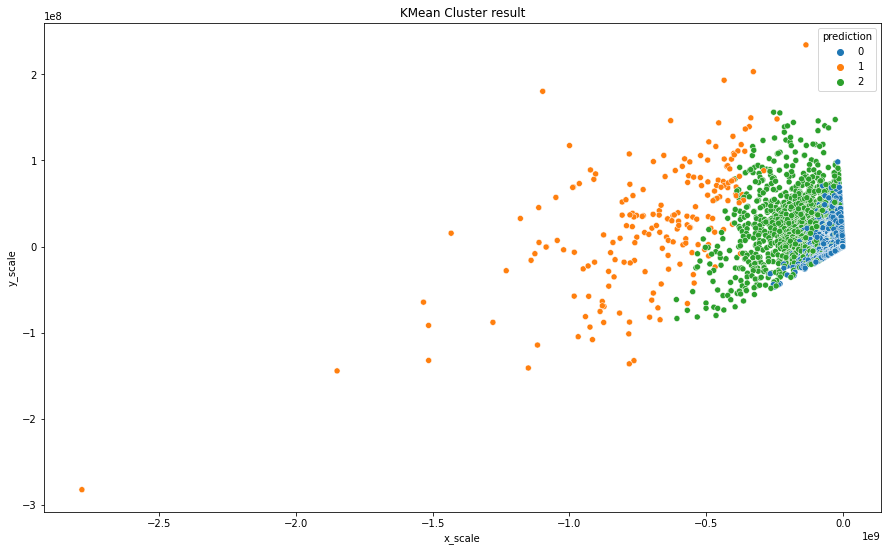

In [ ]:
plt.figure(figsize = (15,9))
sns.scatterplot(x = 'x_scale', y = 'y_scale', hue = 'prediction', palette = 'tab10',data = df3)
plt.title('KMean Cluster result')
plt.show()

In [ ]:
'''
nhóm 0 và nhóm 2 khá bị overlap.
'''

'\nnhóm 0 và nhóm 2 khá bị overlap.\n'

### **WordCloud mỗi nhóm**

In [ ]:
words = df_new2.select('new_overview')

In [ ]:
words = words.withColumn("overview", concat_ws(" ", "new_overview"))


In [ ]:
words = words.withColumn('row_index', f.monotonically_increasing_id())
data_result = data_result.withColumn('row_index', f.monotonically_increasing_id())
words = words.join(data_result, on = ['row_index']).sort('row_index').drop('row_index')

In [ ]:
words = words.toPandas()

In [ ]:
words.head()

,new_overview,overview,prediction
0,in the nd century a paraplegic marine is dis...,in the nd century a paraplegic marine is dis...,1
1,captain barbossa long believed to be dead ha...,captain barbossa long believed to be dead ha...,1
2,a cryptic message from bond s past sends him o...,a cryptic message from bond s past sends him o...,1
3,following the death of district attorney harve...,following the death of district attorney harve...,1
4,john carter is a war weary former military ca...,john carter is a war weary former military ca...,1


In [ ]:
words.prediction.unique()


array([1, 2, 0], dtype=int32)

In [ ]:
# đủ 3 nhóm

In [ ]:
cluster0 = ' '.join(words.new_overview[words.prediction == 0])
cluster1 = ' '.join(words.new_overview[words.prediction == 1])
cluster2 = ' '.join(words.new_overview[words.prediction == 2])

#### **Cluster 0**

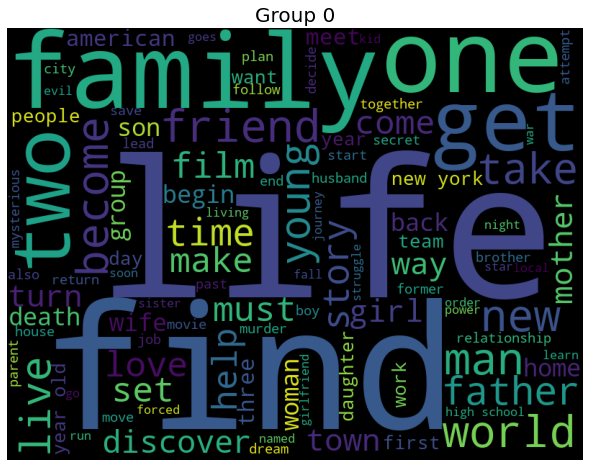

In [ ]:
wordcloud = WordCloud(width = 800, height = 600,
                stopwords = stop_words,
                min_font_size = 10, max_words=100).generate(cluster0)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Group 0', size = 20)
plt.tight_layout(pad = 0)

'''
Nhóm 0 có các key words nổi bật như life, find, friend, family, ...
Nhóm 0 là nhóm có số records nhiều nhất, vì vậy nếu xét về mặt thể loại thì cũng rộng hơn, vd như film về đời sống, film truyền hình, ...
'''

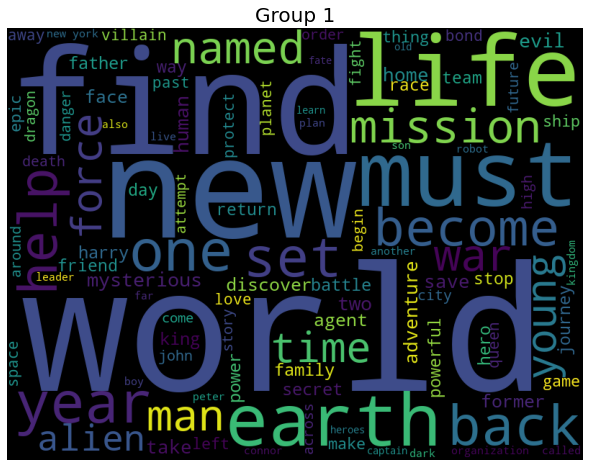

In [ ]:
wordcloud = WordCloud(width = 800, height = 600,
                stopwords = stop_words,
                min_font_size = 10, max_words=100).generate(cluster1)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Group 1', size = 20)
plt.tight_layout(pad = 0)

'''
Nhóm 1 có các keywords như world, earth, mission, ...
Nhìn chung thể loại film của nhóm này giống như là giải cứu trái đất, phiêu lưu mạo hiểm, ...
'''

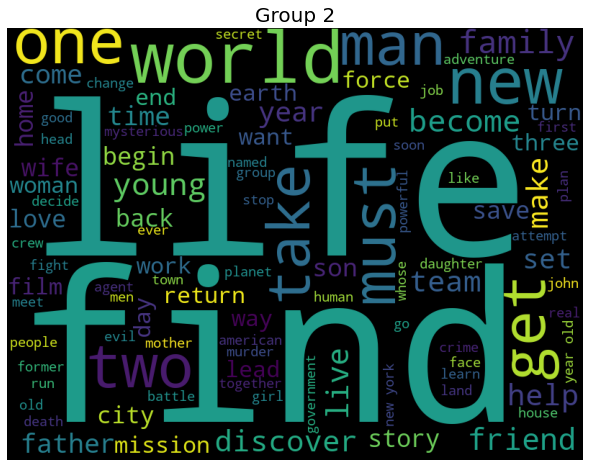

In [ ]:
wordcloud = WordCloud(width = 800, height = 600,
                stopwords = stop_words,
                min_font_size = 10, max_words=100).generate(cluster2)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Group 2', size = 20)
plt.tight_layout(pad = 0)

'''
Với cái keywords như find life, love, man, family, young, ...
Xem ra nhóm này thuộc thể loại phim tình cảm, ...
'''

## **Đánh Giá**

- Kmeans model chia dataset thành 3 nhóm, tuy nhiên có sự không đồng đều và các nhóm có hiện tượng overflap. Nhưng nhìn chung, vẫn có thể thấy và sử dụng được 3 nhóm mà kmeans chia. Có thể dùng thuật toán khác có khả năng chia cụm tốt hơn như GMM, LDA, ...
- Về 3 nhóm mà Kmeans chia, 
    + nhóm 0 có số lượng nhiều nhất, vì vậy thể loại của nó cũng khá rộng. 
    + Nhóm 2 thì nghiêng về thể loại tình cảm, tình bạn, tình gia đình, ...
    + Nhóm 1 chiếm số lượng ít nhất, tuy nhiên từ các keywords, ta thấy đây là các thể loại film hành động, khoa học viễn tưởng => khả năng dc đầu tư số tiền lớn và doanh thu tốt => đây là nhóm vàng.


